# Example Problem: Estimating a model with MLE

This notebook is an example of how to estimate a model using Maximum Likelihood Estimation (MLE). The model we will estimate is a simple linear regression model. The data generating process is as follows:

The Stata data file `PSID_data.dta` provides you with the PSID used by [Heathcoate, Perri, and Violante](http://www.sciencedirect.com/science/article/pii/S1094202509000659) (*Review of Economic Dynamics*, 2010)}.  The raw data are available [here](https://ideas.repec.org/c/red/ccodes/09-214.html).  I've modified this only to deflate the labor incomes of heads and spouses (`hlabinc` and `wlabinc`) to 2005$.

You need to do the following:
1. Select only male heads of household who are between 25 and 60 years of age and earn wages $>$ \$7/hr.
2. Create indicator and continuous variables as necessary (see model below).
3. Estimate the following model via a Maximum Likelihood Estimator separately for $t$ = 1971, 1980, 1990, 2000:
    $$
      ln(w_{i,t}) = \alpha + \beta_{1}Educ_{i,t} + \beta_{2}Age_{i,t} + \beta_{3}Age^2_{i,t} + \beta_{4}Black_{i,t} + \beta_{6}OtherRace_{i,t} + \varepsilon_{i,t},
    $$
    where:

     * $w_{i,t}$ = wage of individual $i$ in survey year $t$
     * $Educ_{i,t}$ = education in years
     * $Age_{i,t}$ = age in years
     * $Black_{i,t}$, $OtherRace_{i,t}$ = dummy variables for race = Black, Not $\in$ \{White, Black}.
4. Interpret the coefficient $\beta_{1}$.  How do the returns to education change over time in these data?
\end{enumerate}

The following variable definitions are provided for your benefit (the [PSID provides further documentation](https://psidonline.isr.umich.edu)):

* `hlabinc` = annual labor income of the head
* `hannhrs` = annual hours of the head
* `hsex` = gender of the head (1=Male, 2=Female)
* `hrace` = race of the head (1=White, 2=Black, 3=Native American, 4=Asian/Pacific Islander, 5=Hispanic, 6,7=Other)
* `age` = age of the head
* `hyrsed` = years of education of the head


**HINT**: This model is linear.  So you can check your MLE against an OLS estimator to confirm your results.  See this [QuantEcon notebook](https://python.quantecon.org/ols.html) for a short tutorial on linear regressions in Python.  Also, you may want a bounded optimizer e.g., try the `L-BFGS-B` and `SLSQP` methods in `scipy.optimize.minimize()`.


In [1]:
# Imports
import pandas as pd
import numpy as np
import scipy.optimize as opt
import scipy.stats as stats
import statsmodels.formula.api as smf

In [2]:
# Read in data
data = pd.read_stata('PSID_data.dta')

In [3]:
# Sample selection and data cleaning
# Choosing only male heads
data = data[data.hsex == 1]
# Dropping individuals who worked 0 hours
data = data[data.hannhrs!=0]
# Keep only those aged 25-60
data = data[(data.age>=25) & (data.age<=60)]
# Defining hourly wage
data['wage'] = data.hlabinc / data.hannhrs
# Keep only those who earn more than $7 per hour
data = data[data.wage>7]
# drop if wage is inf
data = data[data.wage != np.inf]
# Taking log of hourly wage
data['logwage'] = np.log(data.wage)
# Defining race dummies
data['white'] = (data['hrace'] == 1).astype(int)
data['black'] = (data['hrace'] == 2).astype(int)
data['other'] = 1 - data[['white', 'black']].max(axis=1)
# create constant and age squared
data['age_sq'] = data['age'] ** 2
data['const'] = 1

# drop obs if missing values for any variables in regression model
data.dropna(axis=0,
            subset=['logwage', 'hyrsed', 'age', 'age_sq', 'black', 'other'],
            inplace=True)

## Maximum Likelihood Estimation

Log wages are modeled as:
$$
ln(w_{i,t}) = \alpha + \beta_{1}Educ_{i,t} + \beta_{2}Age_{i,t} + \beta_{3}Age^2_{i,t} + \beta_{4}Black_{i,t} + \beta_{5}Hispanic_{i,t} + \beta_{6}OtherRace_{i,t} + \varepsilon_{i,t},
$$

With the assumption that $\varepsilon_{i,t} \sim N(0, \sigma^2)$.

In MLE, we want to find the parameters, $\hat{\beta}$ and $\hat{\sigma}$, that maximize the likelihood of observing the outcome (log wages) conditional on the data.  i.e., for each year (which you will do separately for this question) we want to solve:

$$
max_{\hat{\beta}, \hat{\sigma}}\prod_{i=1}^{N}p(y_{i,t}|x_{i};\hat{\beta}, \hat{\sigma})
$$

With the assumption that $\varepsilon$ is distributed normally with mean zero and variance $\sigma^2$, we know the functional form of the conditional probability function:

$$
\prod_{i=1}^{N}\frac{1}{\sqrt{2\pi \sigma^2}} e^{-\frac{\left(y_{i} - \hat{\beta} x_{i}\right)^2}{2 \hat{\sigma}^2}}
$$

We can estimate this, but it's often simpler to deal with the log-likelihood function:

$$
LL = log \left( \prod_{i=1}^{N}\frac{1}{\sqrt{2\pi \hat{\sigma}^2}} e^{-\frac{\left(y_{i} - \hat{\beta} x_{i}\right)^2}{2 \hat{\sigma}^2}} \right)
$$

$$
LL =  \sum_{i=1}^{N}log \left(\frac{1}{\sqrt{2\pi \hat{\sigma}^2}} e^{-\frac{\left(y_{i} - \hat{\beta} x_{i}\right)^2}{2 \hat{\sigma}^2}}\right)
$$

$$
LL = -\frac{N}{2}log(2\pi) - N log(\hat{\sigma}) - \frac{1}{2\hat{\sigma}^2}\sum_{i=1}^{N}\left( y_{i} - \hat{\beta} x_{i}\right)^2
$$

It's this LL function that we will use to estimate $\beta$, $\sigma$.

### Step 1: Define the statistical objective function

The first thing we'll do then is to write out this statistical objective function that is the LL function.

In [4]:
# Define the objective function
def LogLike(parameters, data):
    """
    The log-likelihood function for the linear regression model.

    Args:
        parameters (tuple): The parameters of the model.
        data (DataFrame): The data used in the model.

    Returns:
        negLL (float): The negative log-likelihood value.
    """
    # unpack the parameters
    alpha, beta1, beta2, beta3, beta4, beta5, sigma = parameters

    # Find predicted y values (note that error = y - yhat)
    yhat = (
        alpha + beta1 * data['hyrsed'] +
        beta2 * data['age'] + beta3 * data['age'] ** 2 +
        beta4 * data['black'] + beta5 * data['other']
        )

    # Calculating the negative log-likelihood assuming the values are normally
    # distributed around the mean (yhat) and standard deviation, sigma
    n = len(data)
    # negLL = (
    #     -1 * (n / 2) * np.log(2 * np.pi) - n * np.log(sigma) -
    #     (1 / (2 * sigma ** 2)) * ((data['logwage'] - yhat) ** 2).sum()) # get some invalid values
    negLL = -np.sum(stats.norm.logpdf(data['logwage'] - yhat, loc=0.0, scale=sigma))
    # negLL = -1 * stats.norm(yhat, sigma).logpdf(data['logwage']).sum()
    # print(negLL)

    return negLL

In [5]:
# Initialize the dictionary to store the results
# Put results into a dictionary
mle_results_dict = {
    'Variable': ['Constant', 'Education', 'Age',
                 r'$Age^2$', 'Black', 'Other', r'$\sigma$',
                 'LL']
                 }

# Loop over years and get MLE estimates for each year
for year in [1971, 1980, 1990, 2000]:
    # Define the data for the year
    data_year = data[data['year'] == year]

    # Define the initial guess at the parameter values
    # initParams = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1.0)
    # initParams = (1.002272, 0.066003, 0.045569, -0.000399, -0.103028, 0.012315, 0.201175)

    initParams = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5)

    # set bounds on parameters
    # only relevant bound is that sigma > 0
    bnds = ((None, None), (None, None), (None, None),
            (None, None), (None, None), (None, None),
            (1e-12, None))

    # Estimate the parameters
    results = opt.minimize(
        LogLike, initParams, args=(data_year,),
        method='L-BFGS-B', bounds=bnds, tol=1e-15
    )
    # then again with better starting values
    # we use results from prior to get starting values
    results = opt.minimize(
        LogLike, results.x, args=(data_year,),
        method="Nelder-Mead", tol=1e-15)

    # Put results into the dictionary
    mle_results_dict[str(year)] = results.x[:]
    mle_results_dict[str(year)] = np.append(mle_results_dict[str(year)], -results.fun)


In [6]:
# Put in DF
mle_results_df = pd.DataFrame(mle_results_dict)
mle_results_df

,Variable,1971,1980,1990,2000
0,Constant,0.585943,1.002142,0.139760,-0.290304
1,Education,0.066502,0.066001,0.095562,0.110318
2,Age,0.064912,0.045577,0.064714,0.084230
3,$Age^2$,-0.000617,-0.000400,-0.000622,-0.000885
4,Black,-0.164416,-0.103066,-0.171858,-0.259761
5,Other,0.017331,0.012395,-0.048297,-0.055439
6,$\sigma$,0.405849,0.447802,0.481552,0.534220
7,LL,-713.706917,-1142.420544,-1385.297396,-2055.324884


In [7]:
# Do estimation with OLS
# Define the model
# Initialize the dictionary to store the results
# Put results into a dictionary
ols_results_dict = {
    'Variable': ['Constant', 'Education', 'Age',
                 r'$Age^2$', 'Black', 'Other', r'$\sigma$',
                 'LL']
                 }
# Loop over years and get MLE estimates for each year
for year in [1971, 1980, 1990, 2000]:
    # Define the data for the year
    data_year = data[data['year'] == year]

    # Specify the model
    model = smf.ols('logwage ~ hyrsed + age + I(age**2) + black + other', data=data_year)
    # Estimate the model
    results = model.fit()

    # Put results into the dictionary
    ols_results_dict[str(year)] = results.params[:]
    ols_results_dict[str(year)] = np.append(ols_results_dict[str(year)], results.scale ** (1/2))
    ols_results_dict[str(year)] = np.append(ols_results_dict[str(year)], results.llf)

In [8]:
# Put in DF
ols_results_df = pd.DataFrame(ols_results_dict)
ols_results_df

,Variable,1971,1980,1990,2000
0,Constant,0.586331,1.002272,0.277243,-0.290220
1,Education,0.066500,0.066003,0.095499,0.110329
2,Age,0.064904,0.045569,0.057864,0.084220
3,$Age^2$,-0.000617,-0.000399,-0.000540,-0.000885
4,Black,-0.164137,-0.103028,-0.167988,-0.259704
5,Other,0.017512,0.012315,-0.052001,-0.055347
6,$\sigma$,0.406740,0.448525,0.482209,0.534861
7,LL,-713.706777,-1142.420589,-1385.080132,-2055.324917


In [9]:
# Compare the two models
diff_df = mle_results_df.copy()
diff_df.iloc[:, 1:] = mle_results_df.iloc[:, 1:] - ols_results_df.iloc[:, 1:]
diff_df

,Variable,1971,1980,1990,2000
0,Constant,-3.885125e-04,-1.295285e-04,-0.137483,-8.344116e-05
1,Education,2.113951e-06,-1.342196e-06,0.000063,-1.174616e-05
2,Age,7.518440e-06,8.709090e-06,0.006850,9.714169e-06
3,$Age^2$,-6.466759e-08,-1.225089e-07,-0.000082,-1.110031e-07
4,Black,-2.788296e-04,-3.772106e-05,-0.003870,-5.672389e-05
5,Other,-1.812869e-04,7.965176e-05,0.003704,-9.174323e-05
6,$\sigma$,-8.913304e-04,-7.228363e-04,-0.000656,-6.405828e-04
7,LL,-1.399859e-04,4.529675e-05,-0.217264,3.366092e-05


<BarContainer object of 4 artists>

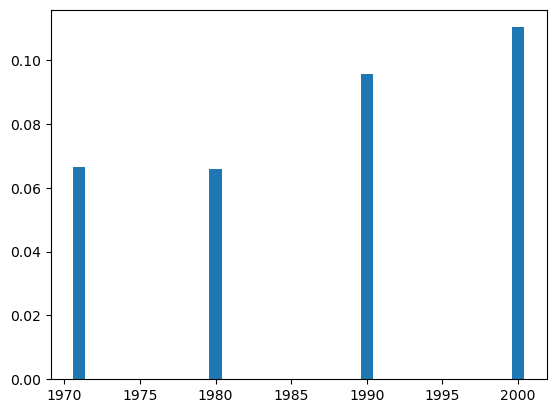

In [12]:
# plot returns to education over time
import matplotlib.pyplot as plt
plt.bar([1971, 1980, 1990, 2000], mle_results_df.loc[mle_results_df.Variable == 'Education', '1971':'2000'].values[0])
